In [14]:
!pip install openai-clip

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB 330.3 kB/s eta 0:00:05
     - -------------------------------------- 0.1/1.4 MB 469.7 kB/s eta 0:00:03
     --- ------------------------------------ 0.1/1.4 MB 656.4 kB/s eta 0:00:02
     ----- ---------------------------------- 0.2/1.4 MB 807.1 kB/s eta 0:00:02
     ---------- ----------------------------- 0.4/1.4 MB 1.4 MB/s eta 0:00:01
     ---------- ----------------------------- 0.4/1.4 MB 1.4 MB/s eta 0:00:01
     ----------- ---------------------------- 0.4/1.4 MB 1.2 MB/s eta 0:00:01
     -------------- ------------------------- 0.5/1.4 MB 1.3 MB/s eta 0:00:01
     ------------------- -------------------- 0.7/1.4 MB 1.5 MB/s eta 0:00:01
     ------------------- -------------------- 0.7/1.4 MB 1.4 MB/s eta 0:00:01
     --------------------- ------------------ 0.7/1.4 MB 1.5 MB/s eta 

In [1]:
import json


In [1]:
#For Loading Images
from PIL import Image

#For displaying loadbar
from tqdm import tqdm

#Importing pytorch to finetune our clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Here, we import clip model developed by meta
import clip

C:\Users\nawaf\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Constructs a CLIP processor which wraps a CLIP image processor and a CLIP tokenizer into a single processor.
from transformers import CLIPProcessor, CLIPModel

In [18]:
json_path = 'train_data.json'
image_path = 'images/train/'

input_data = []
with open(json_path, 'r') as f:
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [2]:
# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load pre-trained CLIP model
#model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
device

'cuda:0'

In [13]:
# Define a custom dataset
class image_title_dataset():
    def __init__(self, list_image_path, list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path

        # Tokenize text using CLIP's tokenizer
        self.title = clip.tokenize(list_txt)

    def __len__(self):
        # Define the length of the dataset
        return len(self.title)

    def __getitem__(self, idx):
        # Get an item from the dataset
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

In [14]:
# use your own data
list_image_path = []
list_txt = []
for item in input_data:
  img_path = image_path + item['image_path'].split('/')[-1]

  #As we have image text pair, we use product title as description.
  caption = item['product_title'][:40]
  list_image_path.append(img_path)
  list_txt.append(caption)

dataset = image_title_dataset(list_image_path, list_txt)
train_dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
#Define your own dataloader

# Function to convert model's parameters to FP32 format
#This is done so that our model loads in the provided memory.
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [15]:
# Check if the device is set to CPU
if device == "cpu":
    model.float()  # Convert the model's parameters to float if using CPU

# Prepare the optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6 ,weight_decay=0.2)

# Adam optimizer is used with specific hyperparameters
# lr (learning rate) is set to 5e-5, which is considered safe for fine-tuning to a new dataset
# betas are used for the optimization algorithm
# eps is a small value to prevent division by zero
# weight_decay adds L2 regularization to the optimizer

# Specify the loss function for images
loss_img = nn.CrossEntropyLoss()

# Specify the loss function for text
loss_txt = nn.CrossEntropyLoss()

In [16]:
import logging
import torch
from tqdm import tqdm

# Setup logging
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Train the model
num_epochs = 4  # Number of training epochs
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    epoch_loss = 0.0  # Initialize loss for the epoch

    # Iterate through the batches in the training data
    for batch in pbar:
        optimizer.zero_grad()  # Zero out gradients for the optimizer

        # Extract images and texts from the batch
        images, texts = batch

        # Move images and texts to the specified device (CPU or GPU)
        images = images.to(device)
        texts = texts.to(device)

        # Forward pass through the model
        logits_per_image, logits_per_text = model(images, texts)

        # Compute the loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        epoch_loss += total_loss.item()  # Accumulate total loss for the epoch

        # Backward pass and update the model's parameters
        total_loss.backward()
        optimizer.step()

        # Update the progress bar with the current epoch and loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item():.4f}")

    # Calculate and log average loss for the epoch
    average_loss = epoch_loss / len(train_dataloader)
    logging.info(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}')

# Save the model after all epochs
torch.save(model.state_dict(), 'final_model.pt')
logging.info("Training complete. Model saved as 'final_model.pt'.")

print("Training complete. Model saved as 'final_model.pt'")

Epoch 4/4, Loss: 3.3906: 100%|██████████| 912/912 [09:50<00:00,  1.54it/s]


Training complete. Model saved as 'final_model.pt'


# Test

In [3]:
import torch
from transformers import CLIPModel, CLIPProcessor

# Load the CLIP model architecture from directory
model = CLIPModel.from_pretrained("Nawaf_custom_clip_finetuned")

# Load the processor
processor = CLIPProcessor.from_pretrained("Nawaf_custom_clip_finetuned_P")

# move to device
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [4]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

Average similarity of incorrect pairings: 20.47


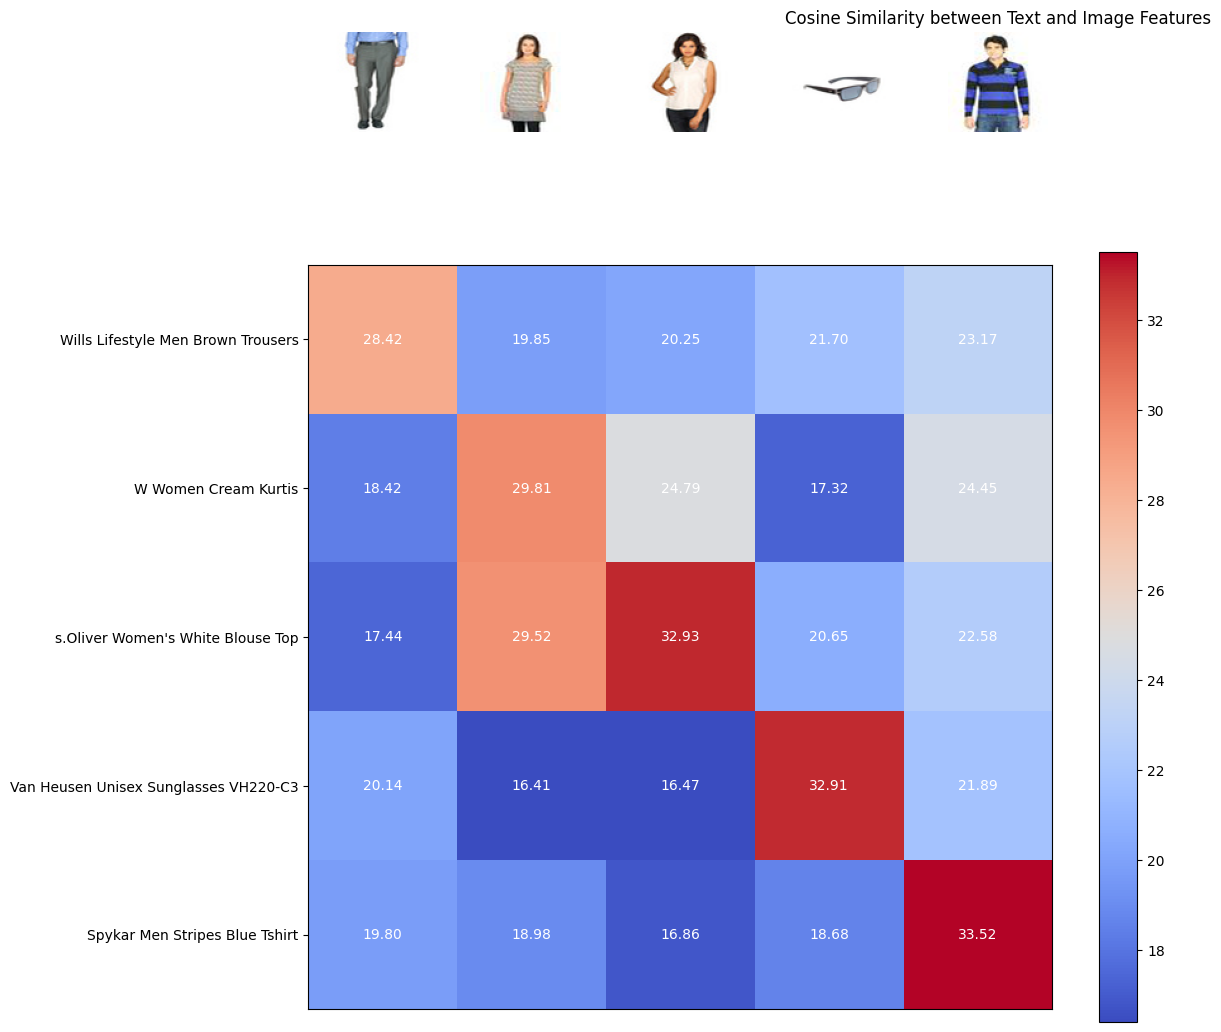

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from PIL import Image
import numpy as np

# Set a fixed random seed for reproducibility
random.seed(40)  # Set the random seed for Python's random module
np.random.seed(42)  # Set the random seed for NumPy (used in pandas sample)

# Load the dataset
data = pd.read_csv('styles.csv')

# Randomly select 5 samples from the dataset (adjust as needed)
random_samples = data.sample(n=5, random_state=40)  # Fix the random state in pandas sample

# Prepare lists for data collection
list_image_path = []
list_txt = []
list_images = []  # To hold the image objects for display
similarity_scores = []

# Collect image paths and descriptions
for _, row in random_samples.iterrows():
    img_filename = f"{row['id']}.jpg"
    img_path = os.path.join('images', img_filename)
    caption = row['productDisplayName']
    if caption.strip().lower() != 'n/a' and caption.strip():
        list_image_path.append(img_path)
        list_txt.append(caption)
        # Load and preprocess image for display
        image = Image.open(img_path)
        image = image.resize((80, 80), Image.Resampling.LANCZOS)  # Resize for better display in the plot
        list_images.append(image)

# Compute similarity and store the results
for img_path, txt in zip(list_image_path, list_txt):
    img_scores = []
    for _, inner_txt in enumerate(list_txt):
        try:
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            continue
        text = clip.tokenize(f"a photo of {inner_txt}").to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).item() * 100
        img_scores.append(similarity)
    similarity_scores.append(img_scores)

# Convert the results into a numpy array for plotting
similarity_matrix = np.array(similarity_scores)

# Calculate the average similarity for incorrect pairings
total_similarity = 0
count = 0
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i != j:  # Skip diagonal elements
            total_similarity += similarity_matrix[i, j]
            count += 1

average_incorrect_similarity = total_similarity / count if count != 0 else 0
print(f"Average similarity of incorrect pairings: {average_incorrect_similarity:.2f}")

# Plot the heatmap using Matplotlib with annotations
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(similarity_matrix, cmap='coolwarm')

# Add a colorbar
fig.colorbar(cax)

# Set descriptions as y-axis labels
ax.set_yticks(np.arange(len(list_txt)))
ax.set_yticklabels(list_txt)

# Remove x-ticks and labels since we will use images
ax.set_xticks([])

# Display images at the top of each column
for i, img in enumerate(list_images):
    ax_img = fig.add_axes([0.13 + i * 0.13, 1.0, 0.1, 0.1], anchor='N')
    ax_img.imshow(img)
    ax_img.axis('off')

# Loop over data dimensions and create text annotations.
for i in range(len(list_txt)):
    for j in range(len(list_txt)):
        ax.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center', color='white')

# Title and labels
plt.title('Cosine Similarity between Text and Image Features')
plt.ylabel('Text Descriptions')

plt.show()


Similarity between image (37103.jpg) and text ('Wills Lifestyle Men Brown Trousers') is 28.42%.


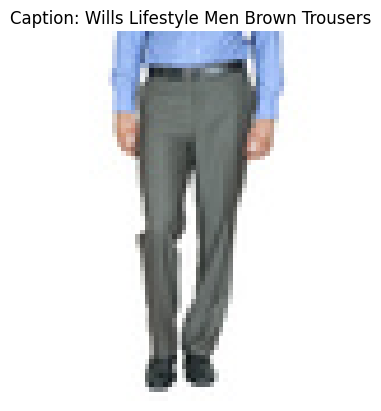

Similarity between image (12107.jpg) and text ('W Women Cream Kurtis') is 29.81%.


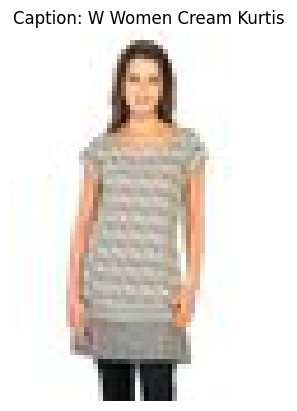

Similarity between image (7019.jpg) and text ('s.Oliver Women's White Blouse Top') is 32.93%.


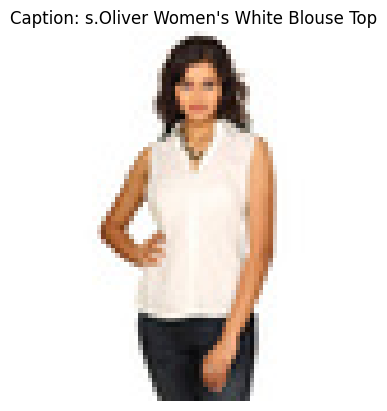

Similarity between image (51702.jpg) and text ('Van Heusen Unisex Sunglasses VH220-C3') is 32.91%.


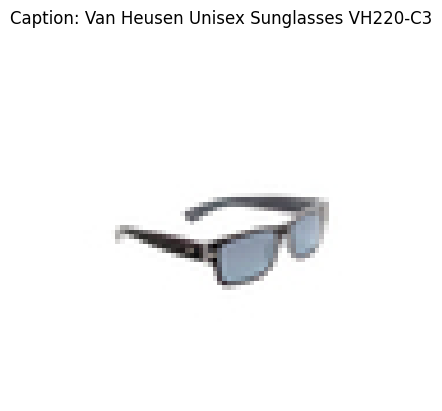

Similarity between image (16926.jpg) and text ('Spykar Men Stripes Blue Tshirt') is 33.52%.


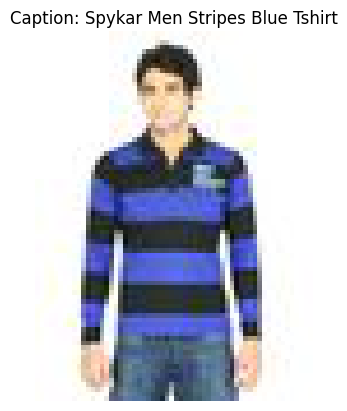

Average similarity across samples is 31.52%.


In [6]:
import matplotlib.pyplot as plt  # For image visualization
import pandas as pd
import os
import random
from PIL import Image  # Make sure to import PIL to use Image

random.seed(40)


# Assuming 'preprocess', 'device', and 'model' are defined elsewhere in your code
# Load the dataset
data = pd.read_csv('styles.csv')

# Randomly select 15 samples from the dataset
random_samples = data.sample(n=5,random_state=40)

# List for storing image paths and text descriptions
list_image_path = []
list_txt = []

for _, row in random_samples.iterrows():
    img_filename = f"{row['id']}.jpg" 
    img_path = os.path.join('images', img_filename)
    caption = row['productDisplayName']
    
    # Check if the caption is N/A or similarly empty/irrelevant text
    if caption.strip().lower() != 'n/a' and caption.strip():
        list_image_path.append(img_path)
        list_txt.append(caption)

# Initialize variables for average calculation
total_similarity = 0
count = 0

# Process each image-text pair and compute similarity
for img_path, txt in zip(list_image_path, list_txt):
    # Load and preprocess the image
    try:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        continue

    # Tokenize and move the text to the device
    text = clip.tokenize(f"a photo of {txt}").to(device)

    # Perform inference
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity score
        similarity = (image_features @ text_features.T).item() * 100
        total_similarity += similarity
        count += 1

    # Print similarity score
    print(f"Similarity between image ({os.path.basename(img_path)}) and text ('{txt}') is {similarity:.2f}%.")

    # Optionally, display the image with its text description
    plt.imshow(plt.imread(img_path))
    plt.title(f"Caption: {txt}")
    plt.axis('off')
    plt.show()

# Calculate and print average similarity
if count > 0:
    average_similarity = total_similarity / count
    print(f"Average similarity across samples is {average_similarity:.2f}%.")
else:
    print("No valid images found to compute similarity.")


# LARGER model

In [8]:
import torch
from transformers import CLIPModel, CLIPProcessor

# Load the CLIP model architecture from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336", use_auth_token=False)

# Load the processor as before
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

# Assuming 'device' is already set to 'cuda' if available or 'cpu' otherwise
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, element

In [9]:
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)

Average similarity of incorrect pairings: 23.18


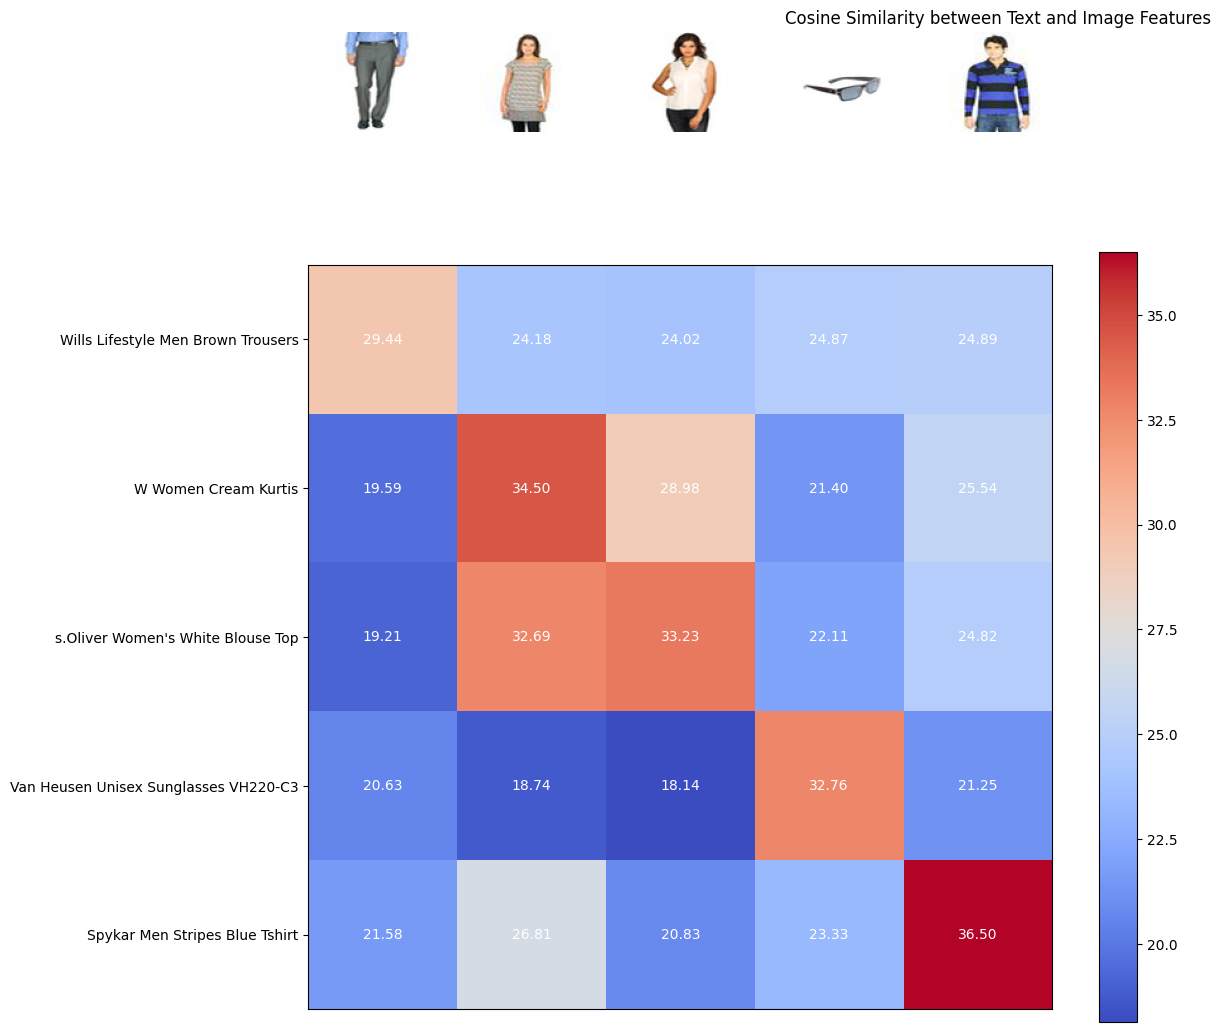

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from PIL import Image
import numpy as np

# Set a fixed random seed for reproducibility
random.seed(40)  # Set the random seed for Python's random module
np.random.seed(42)  # Set the random seed for NumPy (used in pandas sample)

# Load the dataset
data = pd.read_csv('styles.csv')

# Randomly select 5 samples from the dataset (adjust as needed)
random_samples = data.sample(n=5, random_state=40)  # Fix the random state in pandas sample

# Prepare lists for data collection
list_image_path = []
list_txt = []
list_images = []  # To hold the image objects for display
similarity_scores = []

# Collect image paths and descriptions
for _, row in random_samples.iterrows():
    img_filename = f"{row['id']}.jpg"
    img_path = os.path.join('images', img_filename)
    caption = row['productDisplayName']
    if caption.strip().lower() != 'n/a' and caption.strip():
        list_image_path.append(img_path)
        list_txt.append(caption)
        # Load and preprocess image for display
        image = Image.open(img_path)
        image = image.resize((80, 80), Image.Resampling.LANCZOS)  # Resize for better display in the plot
        list_images.append(image)

# Compute similarity and store the results
for img_path, txt in zip(list_image_path, list_txt):
    img_scores = []
    for _, inner_txt in enumerate(list_txt):
        try:
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            continue
        text = clip.tokenize(f"a photo of {inner_txt}").to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).item() * 100
        img_scores.append(similarity)
    similarity_scores.append(img_scores)

# Convert the results into a numpy array for plotting
similarity_matrix = np.array(similarity_scores)

# Calculate the average similarity for incorrect pairings
total_similarity = 0
count = 0
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i != j:  # Skip diagonal elements
            total_similarity += similarity_matrix[i, j]
            count += 1

average_incorrect_similarity = total_similarity / count if count != 0 else 0
print(f"Average similarity of incorrect pairings: {average_incorrect_similarity:.2f}")

# Plot the heatmap using Matplotlib with annotations
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(similarity_matrix, cmap='coolwarm')

# Add a colorbar
fig.colorbar(cax)

# Set descriptions as y-axis labels
ax.set_yticks(np.arange(len(list_txt)))
ax.set_yticklabels(list_txt)

# Remove x-ticks and labels since we will use images
ax.set_xticks([])

# Display images at the top of each column
for i, img in enumerate(list_images):
    ax_img = fig.add_axes([0.13 + i * 0.13, 1.0, 0.1, 0.1], anchor='N')
    ax_img.imshow(img)
    ax_img.axis('off')

# Loop over data dimensions and create text annotations.
for i in range(len(list_txt)):
    for j in range(len(list_txt)):
        ax.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center', color='white')

# Title and labels
plt.title('Cosine Similarity between Text and Image Features')
plt.ylabel('Text Descriptions')

plt.show()


Similarity between image (37103.jpg) and text ('Wills Lifestyle Men Brown Trousers') is 29.44%.


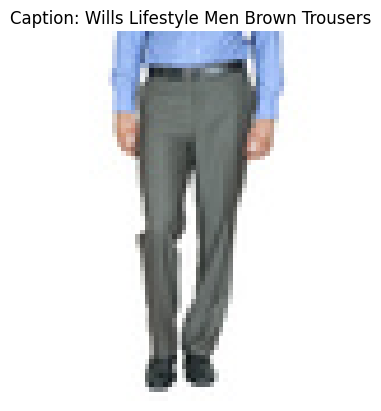

Similarity between image (12107.jpg) and text ('W Women Cream Kurtis') is 34.50%.


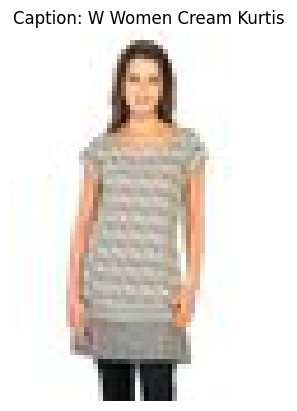

Similarity between image (7019.jpg) and text ('s.Oliver Women's White Blouse Top') is 33.23%.


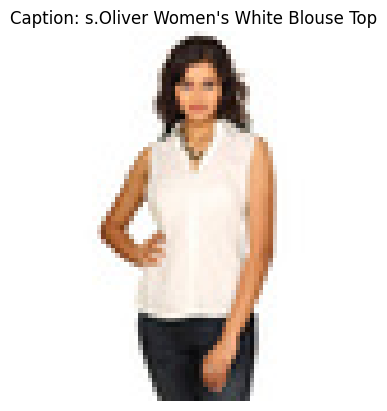

Similarity between image (51702.jpg) and text ('Van Heusen Unisex Sunglasses VH220-C3') is 32.76%.


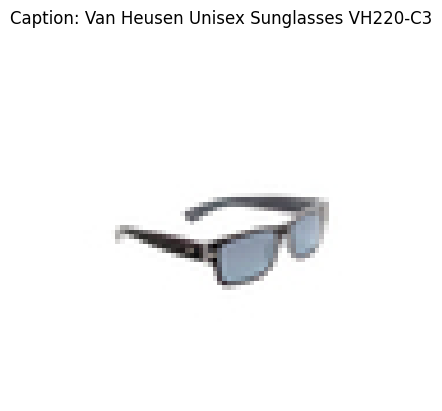

Similarity between image (16926.jpg) and text ('Spykar Men Stripes Blue Tshirt') is 36.50%.


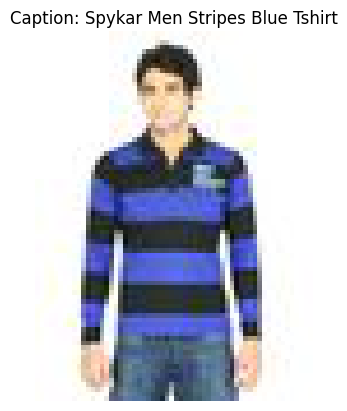

Average similarity across samples is 33.29%.


In [10]:
import matplotlib.pyplot as plt  # For image visualization
import pandas as pd
import os
import random
from PIL import Image  # Make sure to import PIL to use Image

random.seed(40)


# Assuming 'preprocess', 'device', and 'model' are defined elsewhere in your code
# Load the dataset
data = pd.read_csv('styles.csv')

# Randomly select 15 samples from the dataset
random_samples = data.sample(n=5,random_state=40)

# List for storing image paths and text descriptions
list_image_path = []
list_txt = []

for _, row in random_samples.iterrows():
    img_filename = f"{row['id']}.jpg" 
    img_path = os.path.join('images', img_filename)
    caption = row['productDisplayName']
    
    # Check if the caption is N/A or similarly empty/irrelevant text
    if caption.strip().lower() != 'n/a' and caption.strip():
        list_image_path.append(img_path)
        list_txt.append(caption)

# Initialize variables for average calculation
total_similarity = 0
count = 0

# Process each image-text pair and compute similarity
for img_path, txt in zip(list_image_path, list_txt):
    # Load and preprocess the image
    try:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        continue

    # Tokenize and move the text to the device
    text = clip.tokenize(f"a photo of {txt}").to(device)

    # Perform inference
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity score
        similarity = (image_features @ text_features.T).item() * 100
        total_similarity += similarity
        count += 1

    # Print similarity score
    print(f"Similarity between image ({os.path.basename(img_path)}) and text ('{txt}') is {similarity:.2f}%.")

    # Optionally, display the image with its text description
    plt.imshow(plt.imread(img_path))
    plt.title(f"Caption: {txt}")
    plt.axis('off')
    plt.show()

# Calculate and print average similarity
if count > 0:
    average_similarity = total_similarity / count
    print(f"Average similarity across samples is {average_similarity:.2f}%.")
else:
    print("No valid images found to compute similarity.")
